In [1]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None


In [30]:
# 2. data import

#raw_data = np.loadtxt("../data/inductance.csv",delimiter=",")
#raw_data = np.loadtxt("../data/coupling.csv",delimiter=",")
raw_data = np.loadtxt("../data/loss.csv",delimiter=",")

#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","Ltx","Lrx1","Lrx2"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","k12","k13","k23"]
column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","0","freq","loss1","loss2","loss3"]

pd_data = pd.DataFrame(raw_data, columns=column_names)

pd_data.head()


,width0,width1,height0,height1,move,coil0_width,coil1_width,gap0,gap1,0,freq,loss1,loss2,loss3
0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,500.0,250.0,6100.0,2500.0,0.300,20.0,20.0,125.0,50.0,0.0,60.0,242.399485,199.818621,182.512633
2,725.0,275.0,5900.0,2200.0,0.200,20.0,20.0,80.0,25.0,0.0,60.0,293.707407,198.677960,227.137116
3,625.0,300.0,4700.0,2400.0,0.400,20.0,20.0,85.0,30.0,0.0,60.0,222.094685,211.292251,189.930748
4,525.0,250.0,5400.0,2200.0,0.175,20.0,20.0,95.0,50.0,0.0,60.0,249.169424,184.886595,165.960240


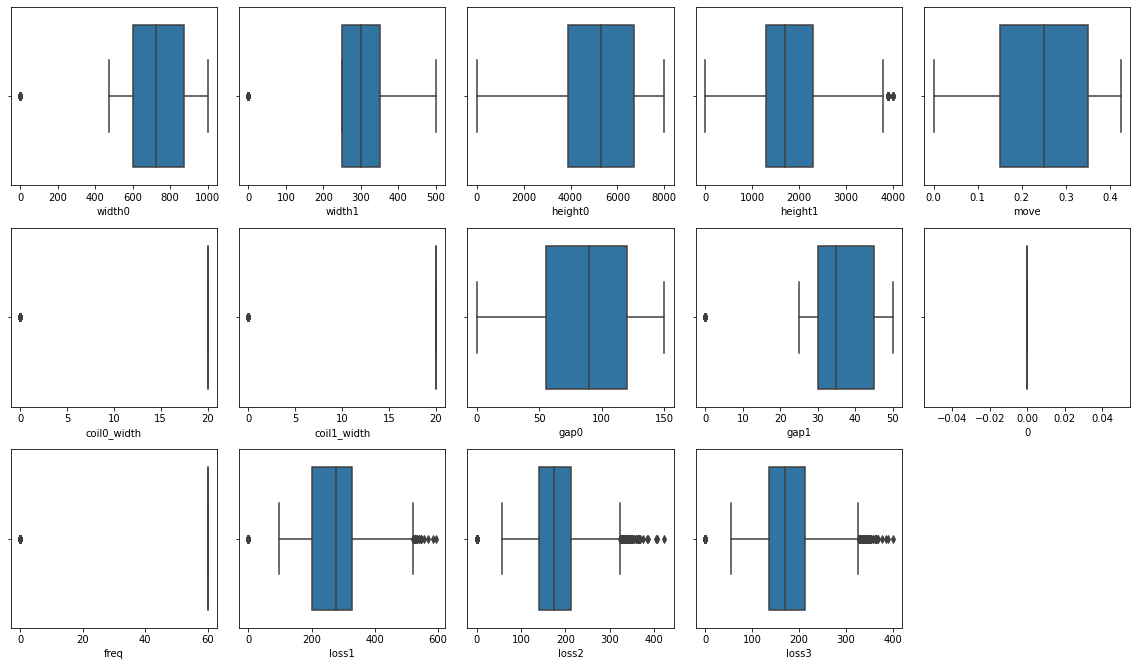

In [31]:
# 4. check outlier

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

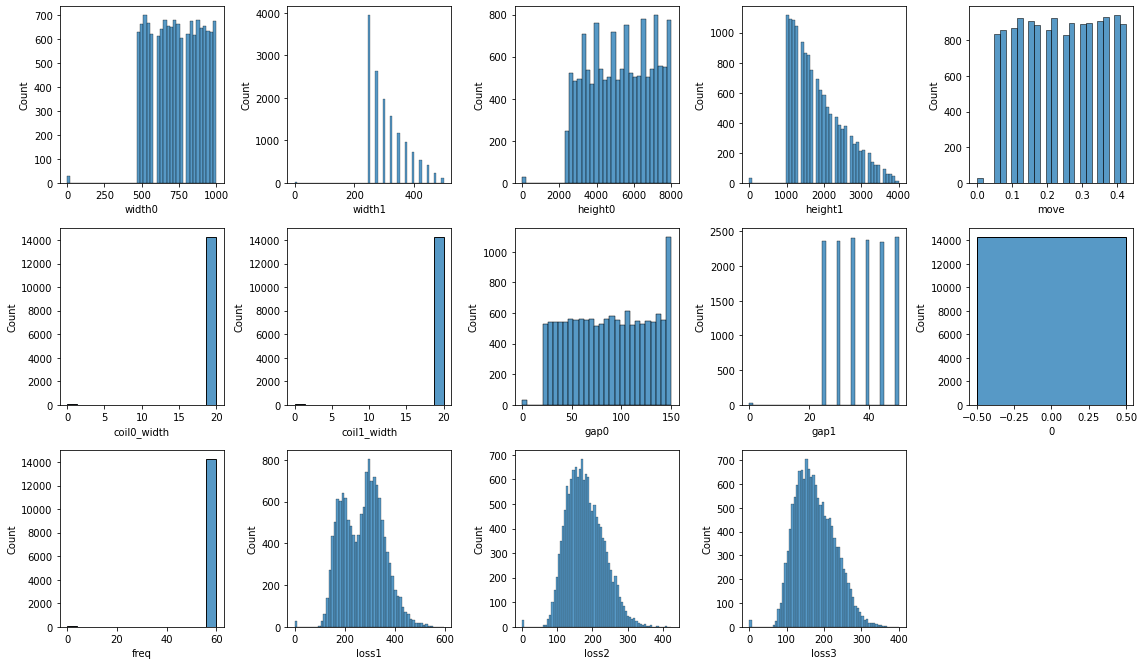

In [32]:
# 5. check data distribution

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

In [34]:
# split input/output

#X = pd_data.drop(columns="Ltx").drop(columns="Lrx1").drop(columns="Lrx2")
#Y = pd_data["Ltx"]

#X = pd_data.drop(columns="k12").drop(columns="k13").drop(columns="k23")
#Y = pd_data["k12"]

X = pd_data.drop(columns="loss1").drop(columns="loss2").drop(columns="loss3")
Y = pd_data["loss1"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

In [35]:
model = LGBMRegressor(random_state=765)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(random_state=765)


[0.8817815697829979, 21.684113652625626, 786.6156944738897, 28.046669935553663, inf, -inf]
[0.8789106639587391, 21.579677638748155, 784.949851554686, 28.016956500567403, inf, -inf]
[0.8827169640469845, 21.71406521741682, 791.8752643626328, 28.140278327739278, inf, -inf]
[0.8886854196836946, 20.85254975251201, 727.5815853745271, 26.973720273157113, inf, -inf]
[0.887297303746187, 21.21859543370182, 744.4532472962616, 27.284670555025244, inf, inf]


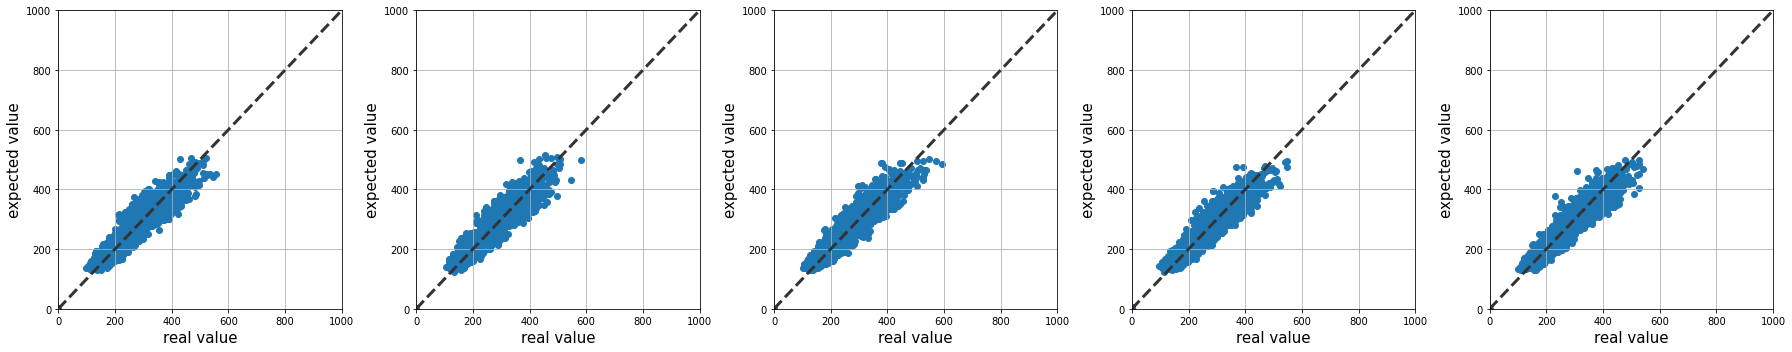

In [37]:
col_input = list(X.columns)

# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.plot([0, 1000], [0, 1000], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()